In [1]:
import sys
import logging
import pickle
import yaml
import matplotlib.cm as cm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import time
import seaborn as sns
import pandas as pd
from configs import engram_dir

# Parameters

In [2]:
episodes = np.arange(0, 650, 50)
episodes = np.arange(0, 650, 100)

In [3]:
internal_dim = 17
generic_exp_name = 'new_gridworld8x8_shuffobs'
network_yaml = 'dm_large_q'
models = ['g0_-2_entro-1',
        'g0.25_-2_entro0',
        'g0.5_-2_entro0',
        'g0.8_-4_entro0']

In [4]:
exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
nnets_dir = f'{engram_dir}nnets/{exp_name}/'
pickle_dir = f'{engram_dir}pickles/{exp_name}/'
analysis_dir = f'{engram_dir}analysis/{exp_name}/'

# Load analysis

In [5]:
dfs = []
for episode in episodes:
    with open(f'{analysis_dir}representation_df_ep{episode}.p', 'rb') as f:
        repr_df = pickle.load(f)
    repr_df.model = repr_df.model.str[len(generic_exp_name)+1:]
    repr_df['episode'] = episode
    dfs.append(repr_df)
dfs = pd.concat(dfs)

In [6]:
results = {
    'inner product': [],
    'model': [],
    'episode': []
    }
iterations = np.unique(dfs['iteration'])
for i in iterations:
    df = dfs[dfs['iteration']==i]
    goal_state = df.iloc[0]['goal_state']
    
    # Collect relevant states
    min_val = np.unique(df['x']).min()
    max_val = np.unique(df['x']).max()
    xys = [
        [min_val, max_val], [min_val, min_val],
        [max_val, min_val], [max_val, max_val]
    ]
            
    # Get pairwise angles
    for idx_1, xy1 in enumerate(xys):
        for xy2 in xys[idx_1+1:]:
            df_xy1 = df[(df['x']==xy1[0])&(df['y']==xy1[1])]
            df_xy2 = df[(df['x']==xy2[0])&(df['y']==xy2[1])]
            for model in models:
                df_xy1_model = df_xy1[df_xy1['model']==model]
                df_xy2_model = df_xy2[df_xy2['model']==model]
                for episode in episodes:
                    _df1 = df_xy1_model[df_xy1_model['episode']==episode]
                    _df2 = df_xy2_model[df_xy2_model['episode']==episode]
                    if len(_df1.index) == 0: continue
                    assert(len(_df1.index)==1)
                    assert(len(_df2.index)==1)
                    arr1 = np.array(_df1.iloc[0]['latents'])
                    arr2 = np.array(_df2.iloc[0]['latents'])
                    sim = np.dot(arr1, arr2)/(np.linalg.norm(arr1)*np.linalg.norm(arr2))
                    results['inner product'].append(sim)
                    results['model'].append(model)
                    results['episode'].append(episode)

In [7]:
df = pd.DataFrame(results)

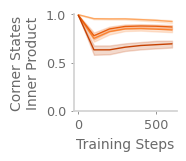

In [11]:
fig, ax = plt.subplots(figsize=(1.75, 1.5), constrained_layout=True)
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
sns.lineplot(y='inner product', x='episode',
    hue_order=models,
    hue='model',
    data=df, legend=None,
    palette=[colors(i) for i in c_steps]
    )
plt.ylim(0,1)
plt.xlabel('Training Steps')
plt.ylabel('Corner States\nInner Product')
plt.savefig('2e.png', dpi=300, transparent=True)
plt.show()

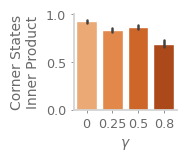

In [18]:
fig, ax = plt.subplots(figsize=(1.75, 1.5), constrained_layout=True)
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
sns.barplot(y='inner product', x='model',
    #hue_order=models,
    #hue='model',
    data=df[df['episode']==600],
    palette=[colors(i) for i in c_steps]
    )
plt.ylim(0,1)
plt.xlabel('$\gamma$')
plt.xticks([0,1,2,3], [0, 0.25, 0.5, 0.8])
plt.ylabel('Corner States\nInner Product')
plt.savefig('2e.png', dpi=300, transparent=True)
plt.show()